# Maxwell Input File
[Link to tutorial](https://www.octopus-code.org/documentation/13/tutorial/maxwell/maxwellinputfile/ )

#### Input file variable description

##### Calculation mode and parallelization strategy


At the beginning of the input file, the basic variable [CalculationMode](https://www.octopus-code.org/documentation//13/variables/calculation_modes/calculationmode) selects the run mode of Octopus and has to be set always.
In case of a parallel run, there are some variables to set the proper
parallelization options. For Maxwell propagations, parallelization in domains
is possible, but parallelization in states is not needed, as there are always 3
or 6 states, depending on the Hamiltonian (see below).

```
CalculationMode = td
```

##### Multisystem setup

The Maxwell system is implemented as part of the Octopus [multisystem](https://www.octopus-code.org/documentation//13/tutorial/multisystem_framework).
This allows to calculate several different systems, which can interact with
each other.

Currently implemented system types are:

* electronic: An electronic system. (only partly implemented)
* maxwell: A maxwell system.
* classical_particle: A classical particle. Used for testing purposes only.
* charged_particle: A charged classical particle.
* multisystem: A container system containing other systems.
* dftbplus: A DFTB+ system
* linear_medium: A (static) linear medium for classical electrodynamics.
* dispersive_medium: A (dispersive) linear medium (only the Drude model is currently implemented)


## Definition of the systems

In this tutorial, we will use a pure Maxwell system:

```
ExperimentalFeatures = yes
%Systems
  'Maxwell' | maxwell
%
```

Subsequently, variables relating to a named system are prefixed by the system
name. However, this prefix is not mandatory for calculations considering only
one system.

## Maxwell box variables and parameters

### Simulation box

The Maxwell simulation box is of parallelepiped shape, and is divided into mainly two
regions: one inner region for the requested propagation and an outer region to simulate the
proper boundary conditions. In the input file, the simulation box sizes
refer to the total simulation box which includes the boundary region. The
inner simulation box is defined by the total box size minus the boundary
width. In case of zero boundary condition, there is no boundary region. 
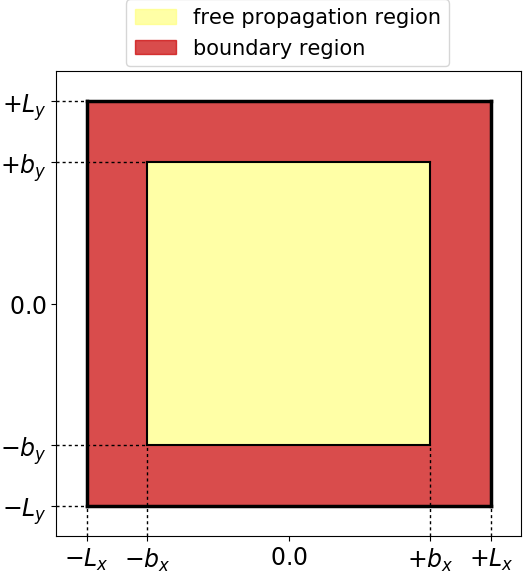

The boundary region can be set up by absorbing boundaries, incident plane waves
or a combination of both. In the latter case, the absorbing boundary region is
the inner boundary region, and the plane waves region is the outer boundary
region. Again, the box sizes are determined by the total simulation box size
and the corresponding boundary width. 

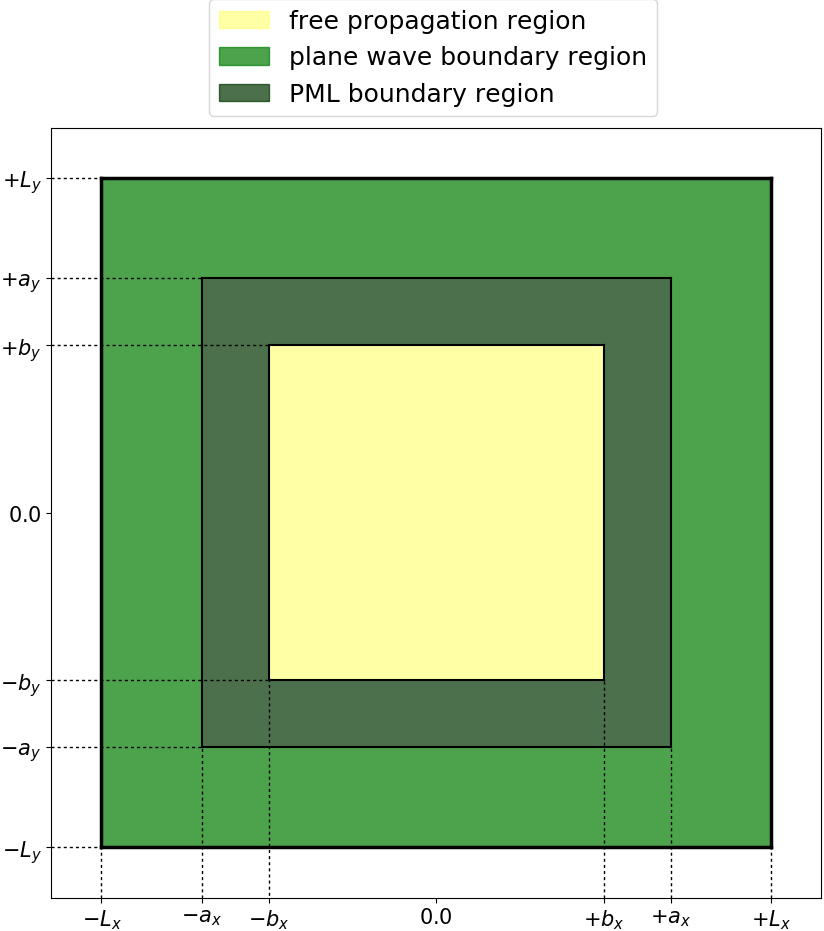

<div class="alert alert-block alert-info"> <b>NOTE</b>
For a given size of the propagation region, the boundaries
have to be added to the total box size. The boundary width is given by the
derivative order (default is 4) times the spacing. The width of the absorbing
boundary region is defined by the variable <a href=TODO>MaxwellABWidth</a>.
</div>

<!---
The matter grid is in general located inside the Maxwell grid. There are
several possible types of grids to describe a coupled Maxwell-matter system.
The following figure illustrates some possible cases overlaying Maxwell and matter
grids. In the Octopus code, currently only the types e), f), and g) are
implemented. So the matter box sizes and Maxwell box sizes can be chosen
independently, whereas the spacings of both grids have to be equal and the grid
points have to lie on the top of each other. The only exception is type g),
where the matter grid is much smaller than the Maxwell grid. In this case, the
matter grid size has to be smaller than the Maxwell grid spacing. {{< figure
caption="Multiscale" src="/images/Maxwell/multiscale_figures.png" width="500px"
>}}
--->


##### Maxwell options

First, the Maxwell propagation operator options consist of the type of `MaxwellHamiltonianOperator`, which normally will be a
Maxwell Hamiltonian for propagation in vacuum (faraday_ampere). This options is also used
for dispersive media. For linear (static) media, one should set the Maxwell-Hamiltonian
that works for a linear medium (faraday_ampere_medium).

Currently, the Maxwell system does not define its own propagator, but uses the
system default propagator, defined in `TDSystemPropagator`. So
far, the exponential midpoint and a leapfrog scheme are implemented (see below).

The Maxwell Boundary conditions can be chosen for each direction differently
with `MaxwellBoundaryConditions`. Possible choices are zero,
plane waves and constant field boundary conditions. Additionally to the boundary condition,
the code can include absorbing boundaries. This means that all outgoing waves are absorbed
while all incoming signals still arise at the boundaries and propagate into
the simulation box. The absorbing boundaries can be achieved by a mask
function or by a perfectly matched layer (PML) calculation with additional
parameters. For more information on the physical meaning of these parameters,
please refer to the [Maxwell-TDDFT paper].

[Maxwell-TDDFT paper]: https://doi.org/10.1080/00018732.2019.1695875


In [ ]:
MaxwellHamiltonianOperator = faraday_ampere

# Boundary conditions for each dimension (zero, constant or plane waves)
%MaxwellBoundaryConditions
plane_waves | plane_waves | plane_waves
%


# Absorbing boundaries option (not absorbing, mask or CPML)s
%MaxwellAbsorbingBoundaries
cpml | cpml | cpml
%

# Absorbing boundary width for the mask or CPML boundaries
MaxwellABWidth = 5.0

# Parameters to tune the Maxwell PML (they have safe defaults)
MaxwellABPMLPower = 2.0
MaxwellABPMLReflectionError = 1e-16

##### Output options

The output option [OutputFormat](https://www.octopus-code.org/documentation//13/variables/output/outputformat) can be used exactly as in the
case of TDDFT calculations, with the exception that some formats are inconsistent
with a Maxwell calculation (like xyz). It is possible to chose multiple
formats. The Maxwell output options are defined in the [MaxwellOutput](https://www.octopus-code.org/documentation//13/variables/output/maxwelloutput) 
block (written to output_iter every [MaxwellOutputInterval](https://www.octopus-code.org/documentation//13/variables/output/maxwelloutputinterval) steps) and through 
the [MaxwellTDOutput](https://www.octopus-code.org/documentation//13/variables/time-dependent/td_output/maxwelltdoutput) (written to td.general every step).



In [ ]:
# Full space-resolved outputs, to be written to the Maxwell/output_iter folder,
# every MaxwellOutputInterval steps (Check variable documentation for full list of possible options)
%MaxwellOutput
  electric_field | axis_z
  magnetic_field | plane_x
%

MaxwellOutputInterval = 10

# Output of the scalar Maxwell variables for each time step, written into the td.general folder
# (the fields are evaluated at all MaxwellFieldsCoordinate points)
MaxwellTDOutput = maxwell_energy + maxwell_total_e_field

# Coordinates of the grid points, which corresponding electromagnetic field values are
# written into td.general/maxwell_fields
%MaxwellFieldsCoordinate
0.00 | 0.00 | 0.00
1.00 | 0.00 | 1.00
%

##### Time step variables

The [TDTimeStep](https://www.octopus-code.org/documentation//13/variables/time-dependent/propagation/tdtimestep) option in general defines the time step used
for each system. For the stability of the time propagation,
Maxwell systems need to fulfill the Courant condition. In some cases larger
time steps are possible but this should be checked case by case.


In [ ]:
TDSystemPropagator = exp_mid

# TDTimeStep should be equal or smaller than the Courant criterion, which is here
# S_Courant = 1 / (sqrt(c^2/dx_mx^2 + c^2/dx_mx^2 + c^2/dx_mx^2))
TDTimeStep = 0.002

# Total simulation time
TDPropagationTime = 0.4

##### Maxwell field variables

The incident plane waves can be defined at the boundaries using the 
[MaxwellIncidentWaves](https://www.octopus-code.org/documentation//13/variables/maxwellstates/maxwellincidentwaves) block. This block defines the incoming wave
type and complex electric field amplitude, and an envelope function
name, which must be defined in a separate [MaxwellFunctions](https://www.octopus-code.org/documentation//13/variables/time-dependent/maxwellfunctions) block. 
Multiple plane waves can be
defined, and their superposition gives the final incident wave result at the
boundary. This plane waves boundaries are evaluated at each time step, and give
the boundary conditions for the propagation inside the box. To use them 
[MaxwellBoundaryConditions](https://www.octopus-code.org/documentation//13/variables/time-dependent/propagation/maxwellboundaryconditions) must be set to "plane_waves" in the
proper directions.

The [MaxwellFunctions](https://www.octopus-code.org/documentation//13/variables/time-dependent/maxwellfunctions) block reads the additional required
information for the plane wave pulse, for each envelope function name given in
the [MaxwellIncidentWaves](https://www.octopus-code.org/documentation//13/variables/maxwellstates/maxwellincidentwaves) block.

Inside the simulation box, the initial electromagnetic field is set up by the
[UserDefinedInitialMaxwellStates](https://www.octopus-code.org/documentation//13/variables/maxwellstates/userdefinedinitialmaxwellstates) block. If the pulse
parameters are such that it is completely outside the box at the initial time,
this variables does not need to be set, as the default initial field inside the
box is zero.

<div class="alert alert-block alert-warning"><b>Warning:</b>
If the incident wave pulse should have initially a non-zero value
inside the box, and [UserDefinedInitialMaxwellStates](https://www.octopus-code.org/documentation//13/variables/maxwellstates/userdefinedinitialmaxwellstates) is not set,
the initial field will be zero by default. This means having a discontinuity
at the boundaries for t=0, which will lead to an erroneous result!
</div>

In case of <code><a href=[TODO](https://www.octopus-code.org/documentation//13/variables//maxwellplanewavesinbox%20)>MaxwellPlaneWavesInBox</a> = yes</code>,
no Maxwell propagation is done, but instead the field
is set analytically at each time step using the parameters defined in [MaxwellIncidentWaves](https://www.octopus-code.org/documentation//13/variables/maxwellstates/maxwellincidentwaves).


In [ ]:
# ----- Maxwell field variables -----------------------------------------------------------------

# Plane waves input block
%MaxwellIncidentWaves
plane_wave_mx_function | Ex1 | Ey1 | Ez1 | "plane_waves_func_1"
%

# Predefined envelope function
%MaxwellFunctions
"plane_waves_func_1" | mxf_cosinoidal_wave | kx1 | ky1 | kz1 | psx1 | psy1 | psz1 | pw1
%

# Definition of the initial EM field inside the box:
# (can be an arbitrary formula, from a file, or using the info from the MaxwellIncidentWaves block)
%UserDefinedInitialMaxwellStates
  use_incident_waves
%

# If incident plane waves should be evaluated analytically inside the simulation box
# (disabling Maxwell propagation, only direct evaluation)
MaxwellPlaneWavesInBox = no

##### External current

An external current can be added to the internal current. Its spatial and
temporal profile are analytical, and the formulas are defined by the
[UserDefinedMaxwellExternalCurrent](https://www.octopus-code.org/documentation//13/variables/maxwellstates/userdefinedmaxwellexternalcurrent) block. This block defines
the spatial profile and frequency of each current source, and it sets an
envelope function name, that must be defined in a separate [TDFunctions](https://www.octopus-code.org/documentation//13/variables/time-dependent/tdfunctions) block.


In [ ]:
# Switch on external current density
ExternalCurrent = yes

# External current profile parameters (spatial profile formulas, frequency and envelope function name)
%UserDefinedMaxwellExternalCurrent
current_td_function | "jx(x.y,z)" | "jy(x,y,z)" | "jz(x,y,z)" | omega | "env_func"
%

# Envelope function in time for the external current density
%TDFunctions
"env_func” | tdf_gaussian | 1.0 | tw | t0
%

##### Linear Medium

Different shapes of dispersive and non-dispersive linear media can be included
in the calculation either through a pre-defined box shape (parallelepiped,
sphere or cylinder), or through a file describing more complex geometries. For
more information check the Linear Medium tutorial.



##### Propagators

The default propagator is an exponential midpoint scheme, as described in the
[Maxwell-TDDFT paper](https://doi.org/10.1080/00018732.2019.1695875); it is selected using
<code><a href=https://www.octopus-code.org/documentation//13/variables/time-dependent/propagation/tdsystempropagator>TDSystemPropagator</a> = prop_expmid</code>.

In addition, a leapfrog propagator is available that is selected with
<code><a href=https://www.octopus-code.org/documentation//13/variables/time-dependent/propagation/tdsystempropagator>TDSystemPropagator</a> = prop_leapfrog</code>.
It uses a simpler scheme for the PML and linear media.
Let us write Maxwell's equations in Riemann-Silberstein formulation as
$$ \partial_t \vec{F}(\vec{r}, t) = H(\vec{F}(\vec{r}, t), t), $$
with the right-hand side $H$ given by
$$  H(\vec{F}(\vec{r}, t), t) = -i c \nabla \times \vec{F}(\vec{r}, t) - \frac{1}{\sqrt{2\epsilon}} \vec{J}(\vec{r}, t). $$
For non-constant permeabilities and permittivities, extra terms appear that
need to be taken into account.

The leapfrog scheme now discretizes the time derivative with a central
finite difference in time:
$$   \vec{F}(\vec{r}_{jkl}, t_{n+1}) = \vec{F}(\vec{r}_{jkl}, t_{n-1}) + 2\Delta t H(\vec{F}(\vec{r}_{jkl}, t_n), t_n), $$
which is a two-level scheme as it depends on the state of the system at the
previous time $t_{n-1}$ ($\vec{r}_{jkl}$ is the discretized space coordinate).
Thus, it requires an additional storage of that Riemann-Silberstein vector. As
this is not available in the first time step, we do a simple forward Euler
step; this approach keeps the scheme accurate to second order.

The leapfrog scheme is stable for purely imaginary eigenvalues of the amplification
matrix, thus it cannot be used for linear media with non-zero conductivities or for
Drude media. In these cases, the terms linear in the fields introduce eigenvalues
with negative real parts.

The stability criterion for the timestep for this scheme is
$$ \Delta t \leq \frac{1}{c \text{max}|\eta|} \left( \sum_{j=1}^3 \frac{1}{\Delta x_j^2} \right)^{-\frac{1}{2}} $$
where $\text{max}|\eta|$ is determined by the Fourier transform of the finite
difference stencil for the first derivatives used in the curl. For the default
8th-order finite differences in Octopus, its value is 1.7306.

In the leapfrog scheme, the curl operation is applied only once which makes it faster
than the exponential midpoint. However, it is only second order in time and thus the
error from time integration can be larger.

[Go to *2-planes-waves-in-vacuum.ipynb*](2-planes-waves-in-vacuum.ipynb)
